In [1468]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime, timedelta

from scipy.stats import mannwhitneyu

# Ввведение

In [1469]:
delivery_data =pd.read_csv("restaurant-orders.csv")

In [1470]:
delivery_data.columns

Index(['Date', 'Time customer placed order', 'Time order placed at restaurant',
       'Time driver arrived at restaurant', 'Delivery time', 'Driver ID',
       'Driver Name', 'Restaurant ID', 'Customer ID', 'Delivery Area', 'ASAP',
       'Sub Total', 'Delivery fee', 'Service fee', 'Discount', 'Tip',
       'Refunded amount'],
      dtype='object')

In [1471]:
delivery_data.isna().sum()

Date                                     0
Time customer placed order               0
Time order placed at restaurant        160
Time driver arrived at restaurant    18124
Delivery time                            0
Driver ID                                0
Driver Name                              0
Restaurant ID                            0
Customer ID                              0
Delivery Area                            0
ASAP                                     0
Sub Total                                0
Delivery fee                             0
Service fee                              0
Discount                                 0
Tip                                      0
Refunded amount                          0
dtype: int64

In [1472]:
delivery_data.head()

,Date,Time customer placed order,Time order placed at restaurant,Time driver arrived at restaurant,Delivery time,Driver ID,Driver Name,Restaurant ID,Customer ID,Delivery Area,ASAP,Sub Total,Delivery fee,Service fee,Discount,Tip,Refunded amount
0,2020-01-01,02:52:12,03:00:25,03:08:09,03:35:20,9329,Christy,7263,1143515,Fremont,Yes,$21.39,$0.43,$3.83,$2.00,$1.40,$0.00
1,2020-01-01,15:58:57,17:56:45,18:24:39,18:57:01,9175,Elizabeth,7247,1136820,Hayward,Yes,$99.74,$6.05,$2.30,$2.00,$11.03,$0.00
2,2020-01-01,19:02:37,19:12:51,19:19:59,19:31:09,9051,Janet,7293,1081871,Hayward,Yes,$21.97,$2.74,$2.39,$8.00,$4.31,$0.00
3,2020-01-01,04:01:57,04:08:18,04:13:02,04:37:57,9389,Jacquelyn,7046,1128255,Union City,Yes,$32.79,$0.12,$2.55,$2.00,$8.55,$0.00
4,2020-01-01,23:46:38,23:49:32,23:54:29,00:37:15,9187,Lauren,7385,1051183,Hayward,Yes,$67.56,$3.77,$3.35,$2.00,$8.82,$0.00


# Предобработка данных

In [1473]:
delivery_data = delivery_data.rename(columns={
    "Time customer placed order":"time_ordered",
    "Time order placed at restaurant":"time_placed",
    "Time driver arrived at restaurant":"time_arrived",
    "Delivery time":"time_delivered",
    "Driver ID":"driver_id",
    "Driver Name":"driver_name",
    "Restaurant ID":"restaurant_id",
    "Customer ID":"customer_id",
    "Delivery Area":"delivery_area",
    "Sub Total":"sub_total",
    "Delivery fee":"delivery_fee",
    "Service fee":"service_fee",
    "Discount":"discount",
    "Tip":"tip",
    "Refunded amount":"refund"
})

In [1474]:
#ML модель основывается на даных для пользователя, колонки водителей и ресторанов излишни
delivery_data = delivery_data.drop(["driver_name","restaurant_id","driver_id"],axis=1)

#Время готовки позиции в ресторане и время приезда курьера в него можно опустить (кроме того данные содрежат много пропусков)
delivery_data = delivery_data.drop(["time_placed","time_arrived"], axis = 1)


In [1475]:
def get_normal_price(refund):
    """получить цену без $"""
    refund = refund[1:]
    return float(refund)

In [1476]:
#Преобразовать цены
delivery_data["refund"] = delivery_data.refund.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["tip"] = delivery_data.tip.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["discount"] = delivery_data.discount.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["service_fee"] = delivery_data.service_fee.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["delivery_fee"] = delivery_data.delivery_fee.astype(str).apply(lambda x: get_normal_price(x))

#есть формат цены 1,000.14
delivery_data["sub_total"] = delivery_data.sub_total.str.replace(",","")
delivery_data["sub_total"] = delivery_data.sub_total.astype(str).apply(lambda x: get_normal_price(x))

In [1477]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund
0,2020-01-01,02:52:12,03:35:20,1143515,Fremont,Yes,21.39,0.43,3.83,2.0,1.40,0.0
1,2020-01-01,15:58:57,18:57:01,1136820,Hayward,Yes,99.74,6.05,2.30,2.0,11.03,0.0
2,2020-01-01,19:02:37,19:31:09,1081871,Hayward,Yes,21.97,2.74,2.39,8.0,4.31,0.0
3,2020-01-01,04:01:57,04:37:57,1128255,Union City,Yes,32.79,0.12,2.55,2.0,8.55,0.0
4,2020-01-01,23:46:38,00:37:15,1051183,Hayward,Yes,67.56,3.77,3.35,2.0,8.82,0.0


# Feature engineering (Базовый)

## Адаптирование времени доставки

In [1478]:
#преобразовываем строковое время в удобный формат времени
time_ordered = delivery_data.time_ordered.apply(lambda x: datetime.strptime(x,"%H:%M:%S"))
time_delivered = delivery_data.time_delivered.apply(lambda x: datetime.strptime(x,"%H:%M:%S"))

time_delta_df = pd.DataFrame({"time_ordered":time_ordered,
                              "time_delivered":time_delivered})

In [1479]:
def get_delivery_minutes(t_ordered, t_delivered):
    # Если время доставки меньше времени заказа, значит, доставка на следующий день
    if t_delivered < t_ordered:
        t_delivered += timedelta(days=1)  # Добавляем 1 день
    
    delta = t_delivered - t_ordered
    return round(delta.total_seconds() / 60)  # Округляем до минут

def get_delivery_time(row):
    dt_ordered = row["time_ordered"]
    dt_delivered = row["time_delivered"]
    return get_delivery_minutes(dt_ordered,dt_delivered)

In [1480]:
#общее время доставки
delivery_time = time_delta_df.apply(get_delivery_time, axis=1)

delivery_data["delivery_time_min"] = delivery_time

In [1481]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time_min
0,2020-01-01,02:52:12,03:35:20,1143515,Fremont,Yes,21.39,0.43,3.83,2.0,1.40,0.0,43
1,2020-01-01,15:58:57,18:57:01,1136820,Hayward,Yes,99.74,6.05,2.30,2.0,11.03,0.0,178
2,2020-01-01,19:02:37,19:31:09,1081871,Hayward,Yes,21.97,2.74,2.39,8.0,4.31,0.0,29
3,2020-01-01,04:01:57,04:37:57,1128255,Union City,Yes,32.79,0.12,2.55,2.0,8.55,0.0,36
4,2020-01-01,23:46:38,00:37:15,1051183,Hayward,Yes,67.56,3.77,3.35,2.0,8.82,0.0,51


## Очистка данных

Посмотрев на график распределения данных можно заметить, что наши данные имеют выбросы

<Axes: xlabel='delivery_time_min', ylabel='Density'>

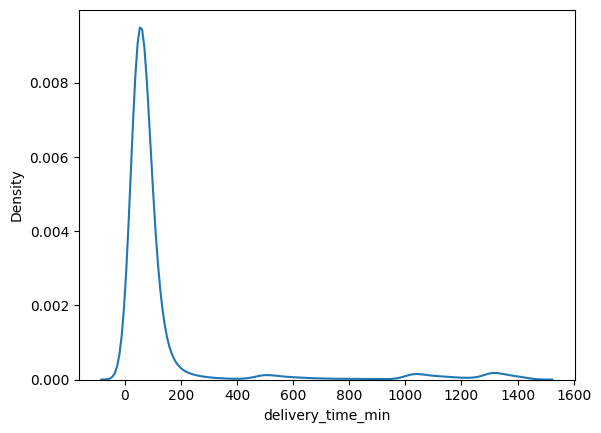

In [1482]:
sns.kdeplot(delivery_data,x="delivery_time_min")

Причем такие выбросы не обусловлен параметром ASAP (As Soon As Possible) в случае, если бы ресторан намеренно отправлял заказ позднее на несколько часов

<Axes: ylabel='delivery_time_min'>

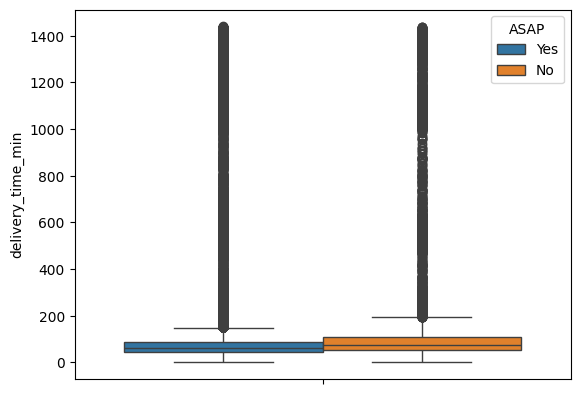

In [1483]:
sns.boxplot(delivery_data,y="delivery_time_min",hue="ASAP")

Посмотрев на случай ниже, можно предположить, что была осуществлена ошибка в сборе данных или заказ был принят в другой день.
Однако из-за формата времени (в 1 ячейке только 1 дата) подтвердить такую гипотезу невозможно.

In [1484]:
delivery_data[delivery_data.delivery_time_min >1400].head(1)

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time_min
627,2020-01-02,18:35:14,18:24:43,1141469,Union City,No,86.85,3.09,1.5,8.0,9.47,0.0,1429


Просмотрим гипотезу о принадлежносте к одной группе данных

<Axes: xlabel='sub_total', ylabel='Density'>

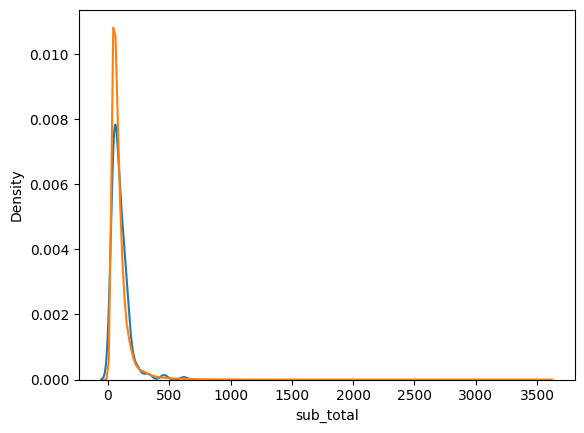

In [1485]:
sns.kdeplot(delivery_data[(delivery_data.delivery_time_min >1400)], x="sub_total")
sns.kdeplot(delivery_data[(delivery_data.delivery_time_min <1400)], x="sub_total")

In [1486]:
print(f"средняя цена товара на длиных доставках:    {delivery_data[delivery_data.delivery_time_min >1400].sub_total.mean()}")
print(f"средняя цена на коротких доставках:   {delivery_data[delivery_data.delivery_time_min <1400].sub_total.mean()}")

print(f"медиана товара на длиных доставках:    {delivery_data[delivery_data.delivery_time_min >1400].sub_total.median()}")
print(f"медиана на коротких доставках:   {delivery_data[delivery_data.delivery_time_min <1400].sub_total.median()}")

средняя цена товара на длиных доставках:    98.62907692307691
средняя цена на коротких доставках:   93.82611912356121
медиана товара на длиных доставках:    77.96
медиана на коротких доставках:   69.85


In [1487]:
print("p-value медиан: ",mannwhitneyu(delivery_data[(delivery_data.delivery_time_min >1400)].sub_total, 
                                      delivery_data[(delivery_data.delivery_time_min <1400)].sub_total).pvalue)

p-value медиан:  0.024143916918196832


статистически значимы, но разница медиан ценового распределения несущественна (8 долларов)

### Фильтрация

In [1488]:
print(f"90% всех меток о времени доставки не превышают {delivery_data.delivery_time_min.quantile(0.90)} минут")

90% всех меток о времени доставки не превышают 169.0 минут


Ввиду малого количества наблюдений и создаваемого шум в данных, было решено избавится от наблюдений после 90-го персенптиля

In [1489]:
#переменная для фильтрации
time_treshhold = delivery_data.delivery_time_min.quantile(0.90)

delivery_data = delivery_data[delivery_data.delivery_time_min < time_treshhold]

# EDA анализ

Неравномерное распределение классов, необходимо уравновешивание классов по формуле: $$n_{samples}/ (n_{classes} * np.bincount(y))$$

In [1490]:
refunds = delivery_data[delivery_data.refund>0].customer_id.count()
non_refunds = delivery_data[delivery_data.refund==0].customer_id.count()

print(f"Количество возратов: {refunds}")
print(f"Количество оформленных заказов: {non_refunds}")
print(f"В процентном соотношении: {refunds / (non_refunds+refunds) *100:.2f}%")

Количество возратов: 1763
Количество оформленных заказов: 63309
В процентном соотношении: 2.71%


## Анализ распределений

### Цена доставки

<Axes: xlabel='sub_total', ylabel='Density'>

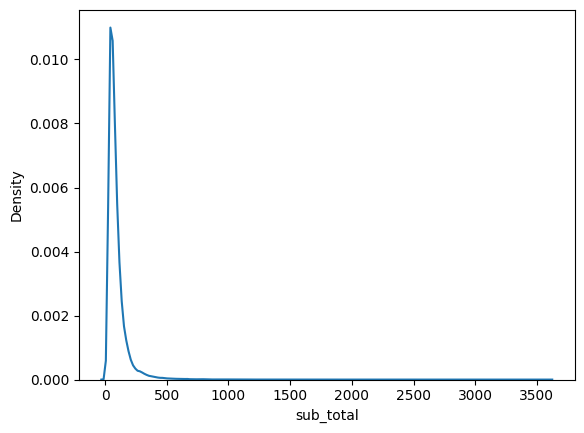

In [1491]:
sns.kdeplot(delivery_data,x="sub_total")

На графике можно заметить, что цена некотых заказов нулевая

In [1492]:
print(f"Количество таких наблюдений: {delivery_data[delivery_data.sub_total==0].customer_id.count()}")

Количество таких наблюдений: 7


In [1493]:
delivery_data[delivery_data.sub_total==0].head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time_min
3935,2020-01-07,00:00:29,01:06:04,1166937,Hayward,Yes,0.0,7.09,3.62,2.0,0.0,83.59,66
12800,2020-01-22,00:06:33,00:47:00,1048629,Hayward,Yes,0.0,1.19,3.12,2.0,0.0,0.00,40
19653,2020-02-03,23:37:06,00:04:04,1065646,Fremont,Yes,0.0,1.62,4.28,3.0,0.0,0.00,27
26851,2020-02-15,04:19:45,04:49:46,1002074,Union City,Yes,0.0,9.71,4.95,3.0,0.0,114.52,30
44056,2020-03-13,03:06:27,04:12:08,1155551,Fremont,Yes,0.0,1.79,4.71,2.0,0.0,0.00,66


Возможные причины такого поведения цены включают ошибки транзакций, ошибки со стороны базы данных. Возможно это даже некоторая мошенническая махинация или системная уязвимость, в любом случае наблюдения любопытны и будут устранены

In [1494]:
#устранение аномалий
delivery_data = delivery_data[delivery_data.sub_total!=0]

<Axes: xlabel='sub_total', ylabel='Density'>

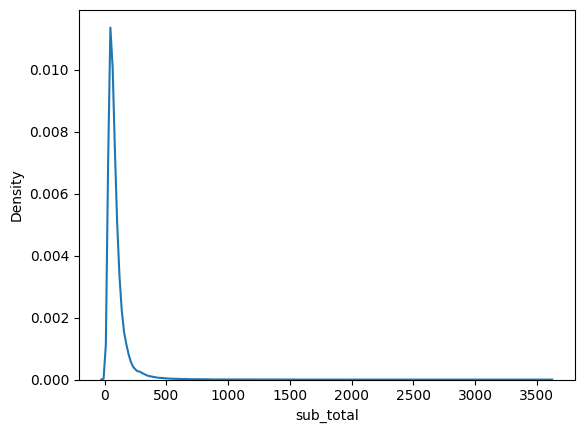

In [1495]:
sns.kdeplot(delivery_data,x="sub_total")

### Побочные ценовые компоненты (сторонние пошлины)

<Axes: xlabel='delivery_fee', ylabel='Density'>

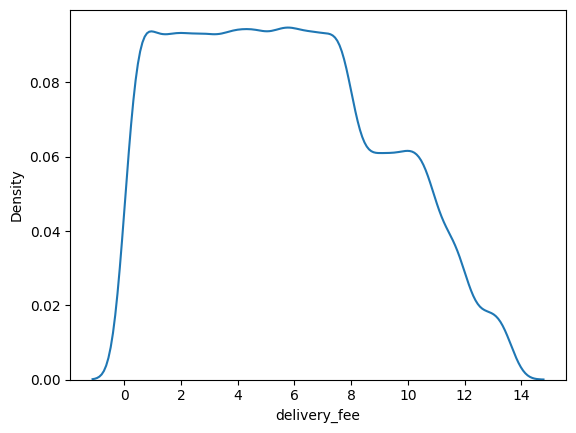

In [1496]:
sns.kdeplot(delivery_data,x="delivery_fee")

<Axes: xlabel='service_fee', ylabel='Density'>

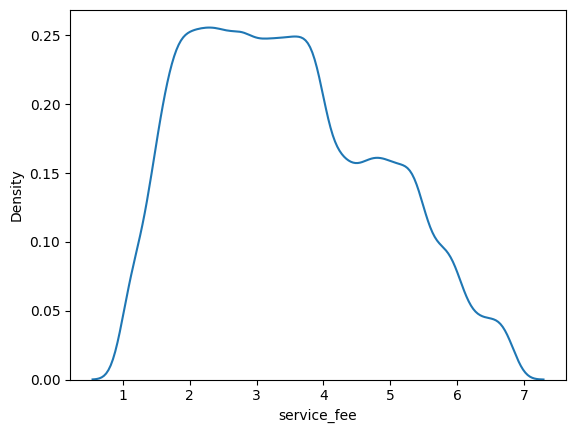

In [1497]:
sns.kdeplot(delivery_data,x="service_fee")

<Axes: xlabel='discount', ylabel='Density'>

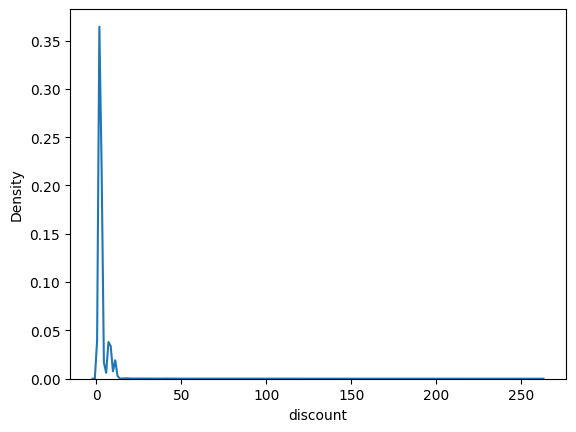

In [1498]:
sns.kdeplot(delivery_data,x="discount")

<Axes: xlabel='tip', ylabel='Density'>

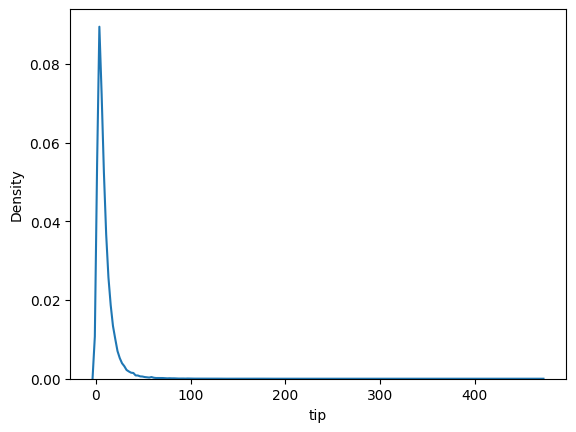

In [1499]:
sns.kdeplot(delivery_data,x="tip")

# Устранение выбросов

Для цены товара используем обратную конвертацию ("сжимаем большие цены к началу, отдавая приоритет меньшим значениям")

In [1500]:
delivery_data["sub_total"] = 1 / delivery_data.sub_total

In [1501]:
print(f"99-й персенптиль обратной стоимости товара: {delivery_data.sub_total.quantile(0.99):.2f}")\

threshold = delivery_data.sub_total.quantile(0.99)
# delivery_data = delivery_data[delivery_data.sub_total <=threshold]

delivery_data["sub_total"] = delivery_data["sub_total"].clip(upper=threshold)

99-й персенптиль обратной стоимости товара: 0.05


<Axes: xlabel='sub_total', ylabel='Density'>

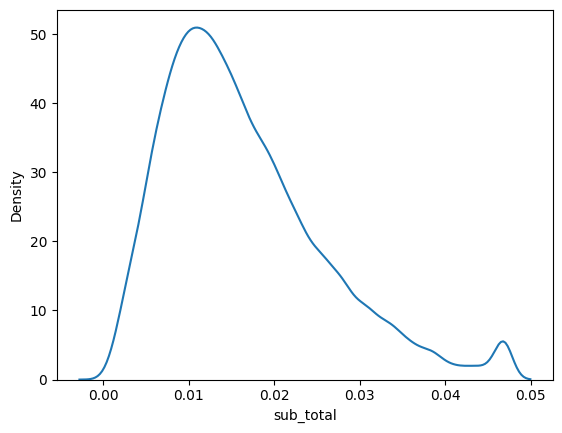

In [1502]:
sns.kdeplot(delivery_data,x="sub_total")

In [1503]:
#заменим ценовой discount на экивалент % от стоимости 
delivery_data["discount"] = (delivery_data.discount / (1/delivery_data.sub_total)) *100

#тоже самое с tip
delivery_data["tip"] = (delivery_data.tip / (1/delivery_data.sub_total) )*100

<Axes: xlabel='discount', ylabel='Density'>

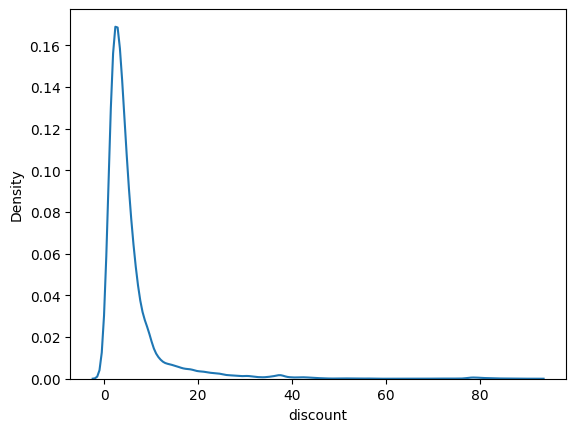

In [1504]:
sns.kdeplot(delivery_data,x="discount")

In [1505]:
# threshold = delivery_data.discount.quantile(0.99)

# delivery_data["discount"] = delivery_data["discount"].clip(upper=threshold)

In [1506]:
delivery_data["discount"] = np.sqrt(delivery_data.discount)

<Axes: xlabel='discount', ylabel='Density'>

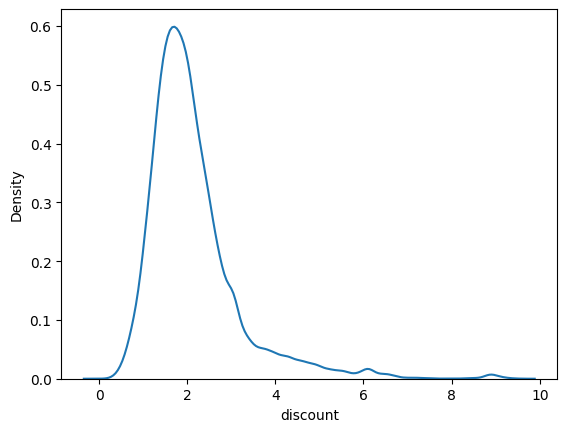

In [1507]:
sns.kdeplot(delivery_data,x="discount")

<Axes: xlabel='tip', ylabel='Density'>

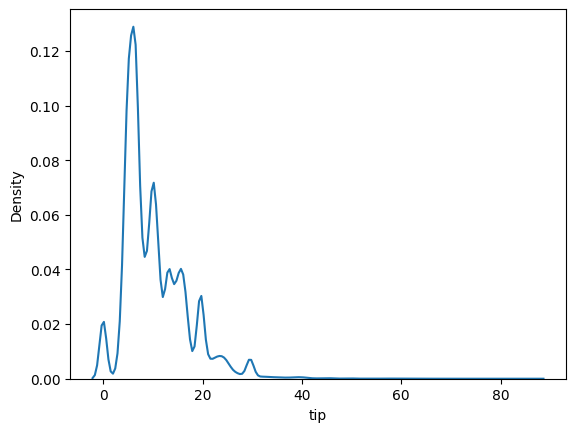

In [1508]:
sns.kdeplot(delivery_data,x="tip")

In [1509]:
delivery_data["tip"] = np.sqrt(delivery_data.tip)

<Axes: xlabel='tip', ylabel='Density'>

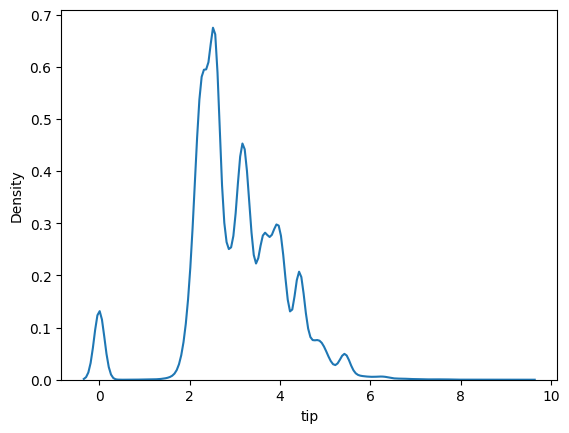

In [1510]:
sns.kdeplot(delivery_data,x="tip")

# Замена классифицируемой переменной на фактор

In [1512]:
delivery_data["refund"] = delivery_data.refund >0

## Анализ корреляций

In [1513]:
sns.boxplot(delivery_data[delivery_data],y="discount",hue="refund")

ValueError: Boolean array expected for the condition, not object

<Axes: xlabel='discount', ylabel='refund'>

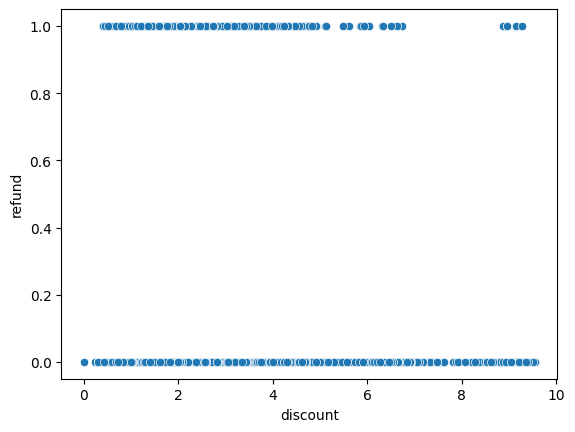

In [1514]:
sns.scatterplot(delivery_data,x= "discount",y="refund")

<Axes: xlabel='delivery_fee', ylabel='sub_total'>

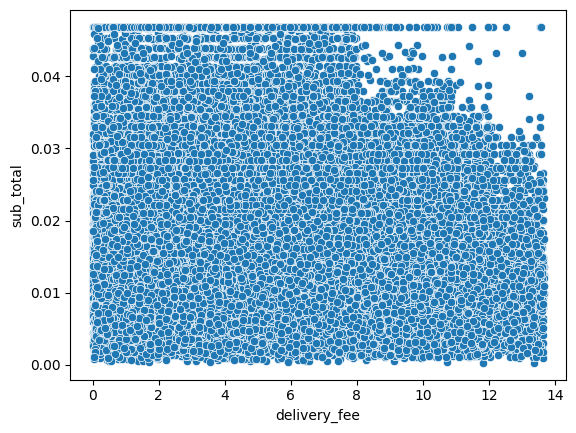

In [1517]:
sns.scatterplot(delivery_data,x="delivery_fee",y="sub_total")

<Axes: xlabel='tip', ylabel='Proportion'>

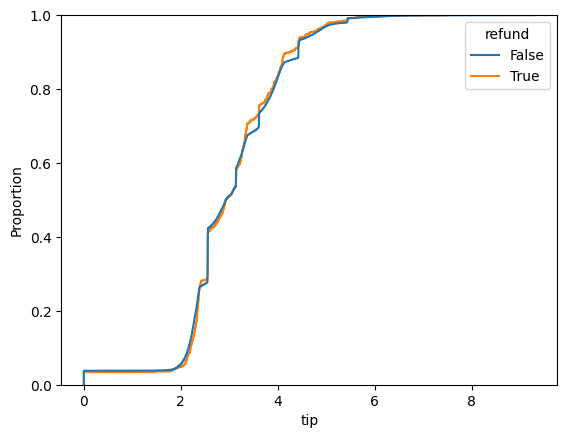

In [1518]:
sns.ecdfplot(delivery_data,x="tip", hue="refund")

<Axes: xlabel='ASAP', ylabel='delivery_time_min'>

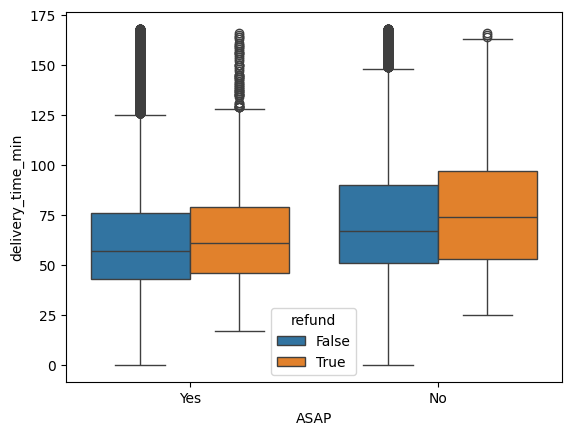

In [1519]:
sns.boxplot(delivery_data, x="ASAP",y="delivery_time_min", hue="refund")

<Axes: xlabel='delivery_time_min', ylabel='sub_total'>

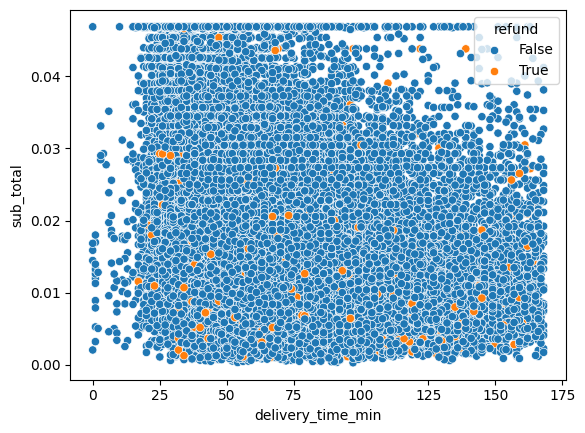

In [1520]:
sns.scatterplot(delivery_data,x = "delivery_time_min", y="sub_total", hue="refund")

<Axes: xlabel='delivery_time_min', ylabel='refund'>

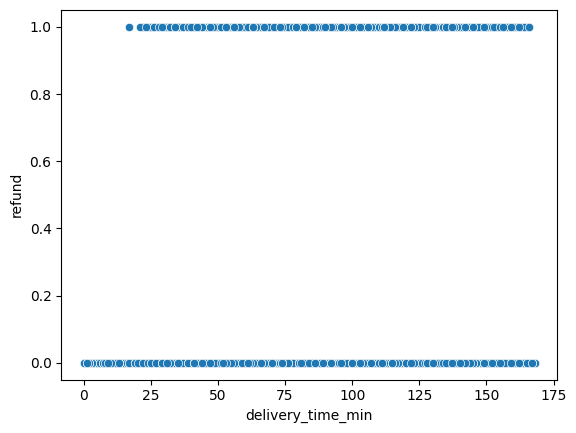

In [1521]:
sns.scatterplot(delivery_data,x = "delivery_time_min", y="refund")

<Axes: xlabel='delivery_time_min', ylabel='ASAP'>

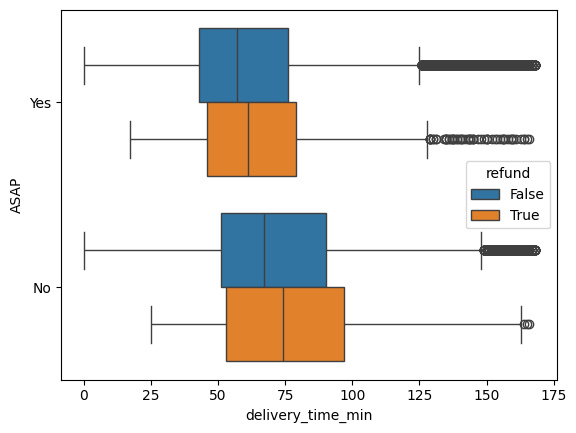

In [1522]:
sns.boxplot(delivery_data,x = "delivery_time_min", y="ASAP", hue="refund")

## Гипотезы 

<Axes: xlabel='delivery_fee', ylabel='sub_total'>

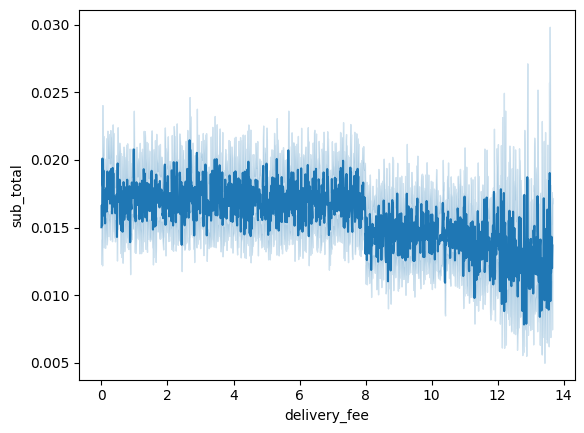

In [1523]:
sns.lineplot(delivery_data,x="delivery_fee", y="sub_total")

<Axes: xlabel='service_fee', ylabel='sub_total'>

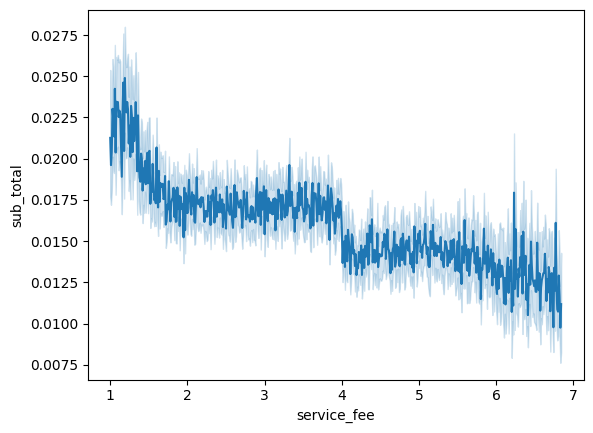

In [1524]:
sns.lineplot(delivery_data,x="service_fee",y="sub_total")

<Axes: xlabel='service_fee'>

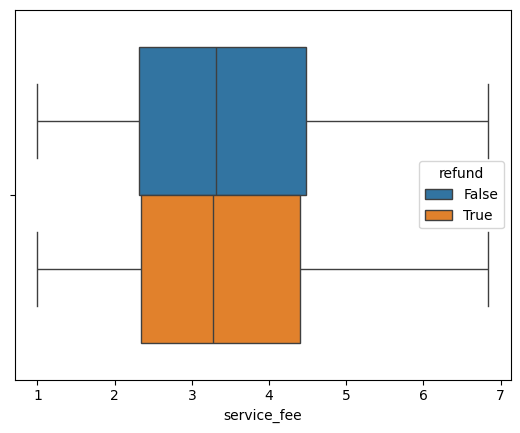

In [1525]:
sns.boxplot(delivery_data, x="service_fee", hue="refund")

<Axes: xlabel='delivery_fee'>

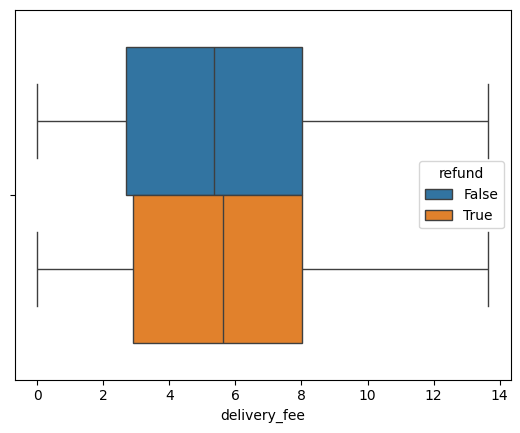

In [1526]:
sns.boxplot(delivery_data, x="delivery_fee", hue="refund")